### Modelio paruošimas mokymui

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Duomenys iš https://www.cs.toronto.edu/~kriz/cifar.html
# Keras prie jų suteikia dar palengvintą prieigą
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# X = np.concatenate((train_images,test_images))
# Y = np.concatenate((train_labels,test_labels))
# train_images, test_images, test_labels, validation_labels = train_test_split(
#     X, Y, train_size=0.8, random_state=1)

In [3]:
# Klasių pavadinimai
classes_labels = np.char.title(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

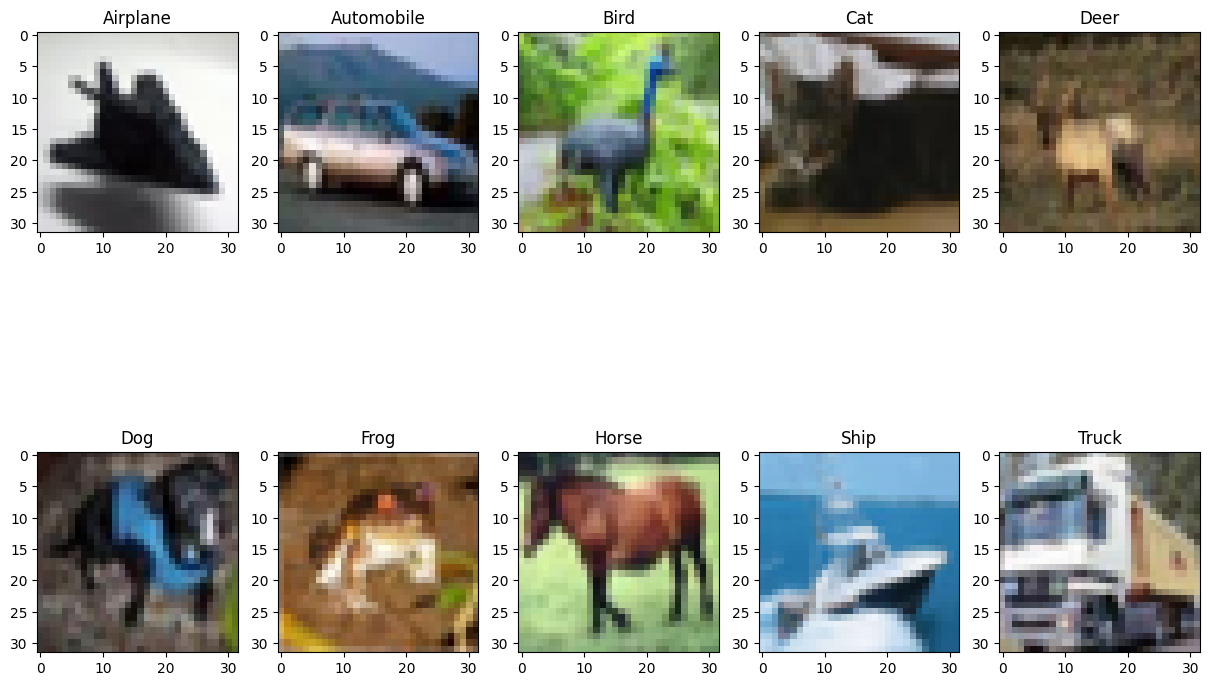

In [4]:
# Kiekvienos klasės pavyzdys
fig, ax = plt.subplots(2,5,figsize=(15, 10))
for i in range(0,10):
    indice = np.where(train_labels == i)[0][0]
    ax[i//5,i%5].imshow(train_images[indice])
    ax[i//5,i%5].set_title(classes_labels[i])

In [5]:
# modelio sudarymas
def build_model(activation):
    inputs = tf.keras.Input(shape=(32,32,3,))
      
  # x = layers.RandomFlip("horizontal")(inputs),
  # x = layers.RandomRotation(0.1),
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation=activation)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation=activation)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation=activation)(x)
    output = layers.Dense(10)(x)

    model = tf.keras.Model(inputs, output)
    
    return model

In [6]:
# sudaryto modelio pavaizdavimas
model = build_model('relu')
model.summary()
tf.keras.utils.plot_model(model, "CNN_model_structure.png")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                         

In [7]:
# modelio mokymas
def train_model(train_images,train_labels,
                activation = "relu",
                batch_size = 32,
                optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"],
                attempt = 1):
    
    model = build_model(activation)
    
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    tensorboard_callback = tf.keras.callbacks.TensorBoard('logs', histogram_freq=1)
    modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="modeliai/" + "hyperparameter_set_" + str(attempt) + "/epoch_{epoch}",
        save_freq='epoch',
        save_best_only=True)

    history = model.fit(train_images, train_labels, epochs=10, 
                        validation_split=0.2, 
                        verbose = 2, batch_size = batch_size,
                        callbacks=[tensorboard_callback,modelcheckpoint_callback])
    
    return model, history

In [8]:
# modelio įvertinimas
def evaluate_model(model,history,test_images,test_labels,**kwargs):
    
    plt.plot(history.history['accuracy'], label='Mokymo duomenys')
    plt.plot(history.history['val_accuracy'], label = 'Validacijos duomenys')
    plt.xlabel('Epocha')
    plt.ylabel('Tikslumas')
    plt.legend(loc='lower right')
    plt.title(kwargs.__str__())
    plt.show()
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
    print("Modelio tikslumas: ", round(test_accuracy,2))
    
    return test_loss, test_accuracy

In [9]:
# mokymas ir įvertinimas
def pipeline(train_images,train_labels,
             test_images,test_labels,
             activation="relu",
             batch_size=32,
             optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"],
             attempt = 1):
    
    model, history = train_model(train_images,train_labels,
                                 activation,batch_size,
                                 optimizer,loss,metrics,attempt)
    _, test_accuracy = evaluate_model(model,history,test_images,test_labels,
                                      activation=activation,
                                      batch_size=batch_size,
                                     optimizer=optimizer)
    return model, history, test_accuracy

In [10]:
# hiperparametrai, kurių įtaką tikrinsiu
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid({"activation":["relu","sigmoid"],"batch_size":[32,64,128],"optimizer":["sgd","adam"]})

results = pd.DataFrame(list(grid))

test_accuracies = []
models = []
histories = []

### Modelių mokymas

In [132]:
%load_ext tensorboard
%tensorboard --logdir logs

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_1/assets
1250/1250 - 11s - loss: 2.0471 - accuracy: 0.2433 - val_loss: 1.8363 - val_accuracy: 0.3339 - 11s/epoch - 9ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_2/assets
1250/1250 - 11s - loss: 1.7084 - accuracy: 0.3826 - val_loss: 1.5901 - val_accuracy: 0.4292 - 11s/epoch - 8ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_3/assets
1250/1250 - 11s - loss: 1.5314 - accuracy: 0.4477 - val_loss: 1.4819 - val_accuracy: 0.4652 - 11s/epoch - 8ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_4/assets
1250/1250 - 11s - loss: 1.4290 - accuracy: 0.4859 - val_loss: 1.3925 - val_accuracy: 0.5011 - 11s/epoch - 9ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_0/epoch_5/assets
1250/1250 - 11s - loss: 1.3571 - accuracy: 0.5153 - val_loss: 1.3223 - val_accuracy: 

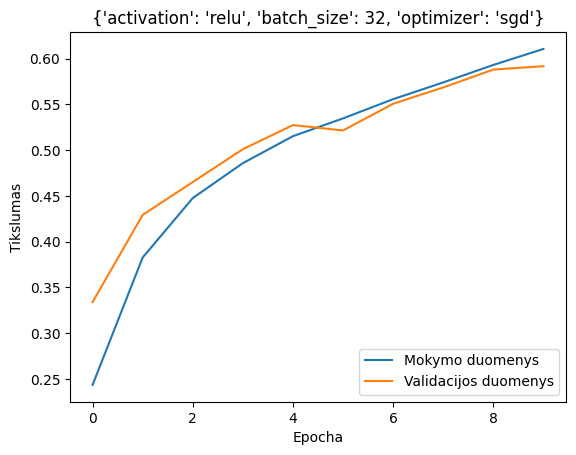

313/313 - 1s - loss: 1.1534 - accuracy: 0.5929 - 708ms/epoch - 2ms/step
Modelio tikslumas:  0.59


In [22]:
i = 0

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_1/assets
1250/1250 - 11s - loss: 1.5784 - accuracy: 0.4182 - val_loss: 1.3303 - val_accuracy: 0.5286 - 11s/epoch - 9ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_2/assets
1250/1250 - 11s - loss: 1.2187 - accuracy: 0.5658 - val_loss: 1.1658 - val_accuracy: 0.5805 - 11s/epoch - 9ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_3/assets
1250/1250 - 11s - loss: 1.0704 - accuracy: 0.6224 - val_loss: 1.0734 - val_accuracy: 0.6298 - 11s/epoch - 9ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_4/assets
1250/1250 - 11s - loss: 0.9739 - accuracy: 0.6606 - val_loss: 0.9875 - val_accuracy: 0.6477 - 11s/epoch - 9ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_1/epoch_5/assets
1250/1250 - 11s - loss: 0.8931 - accuracy: 0.6848 - val_loss: 0.9833 - val_accuracy: 

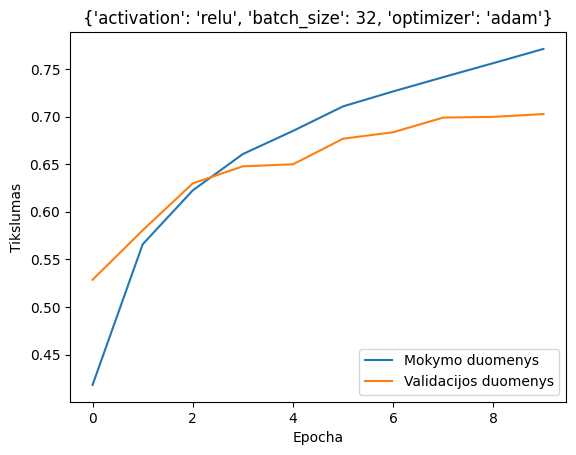

313/313 - 1s - loss: 0.8977 - accuracy: 0.7018 - 729ms/epoch - 2ms/step
Modelio tikslumas:  0.7


In [23]:
i = 1

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_1/assets
625/625 - 9s - loss: 2.2054 - accuracy: 0.1864 - val_loss: 2.0542 - val_accuracy: 0.2535 - 9s/epoch - 15ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_2/assets
625/625 - 9s - loss: 1.9832 - accuracy: 0.2743 - val_loss: 1.9182 - val_accuracy: 0.2929 - 9s/epoch - 14ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_3/assets
625/625 - 9s - loss: 1.8694 - accuracy: 0.3253 - val_loss: 1.7874 - val_accuracy: 0.3570 - 9s/epoch - 14ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_4/assets
625/625 - 9s - loss: 1.7408 - accuracy: 0.3756 - val_loss: 1.7017 - val_accuracy: 0.3895 - 9s/epoch - 14ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_2/epoch_5/assets
625/625 - 9s - loss: 1.6092 - accuracy: 0.4186 - val_loss: 1.5428 - val_accuracy: 0.4443 - 9s/epo

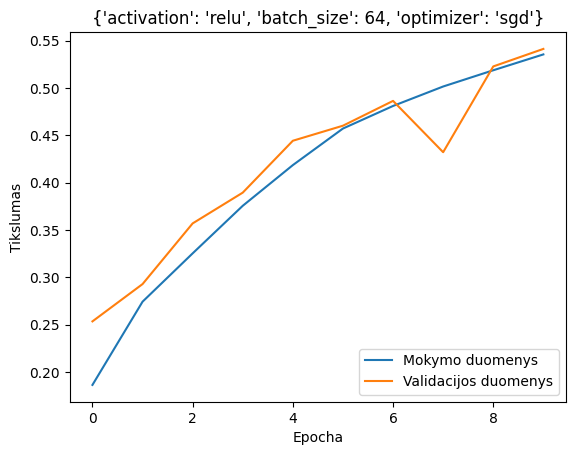

313/313 - 1s - loss: 1.3042 - accuracy: 0.5363 - 706ms/epoch - 2ms/step
Modelio tikslumas:  0.54


In [24]:
i = 2

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_1/assets
625/625 - 10s - loss: 1.6302 - accuracy: 0.3995 - val_loss: 1.4586 - val_accuracy: 0.4803 - 10s/epoch - 15ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_2/assets
625/625 - 9s - loss: 1.2912 - accuracy: 0.5378 - val_loss: 1.2572 - val_accuracy: 0.5529 - 9s/epoch - 15ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_3/assets
625/625 - 9s - loss: 1.1397 - accuracy: 0.5958 - val_loss: 1.1162 - val_accuracy: 0.6067 - 9s/epoch - 15ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_4/assets
625/625 - 9s - loss: 1.0395 - accuracy: 0.6357 - val_loss: 1.0493 - val_accuracy: 0.6274 - 9s/epoch - 15ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_3/epoch_5/assets
625/625 - 9s - loss: 0.9669 - accuracy: 0.6619 - val_loss: 0.9945 - val_accuracy: 0.6543 - 9s/e

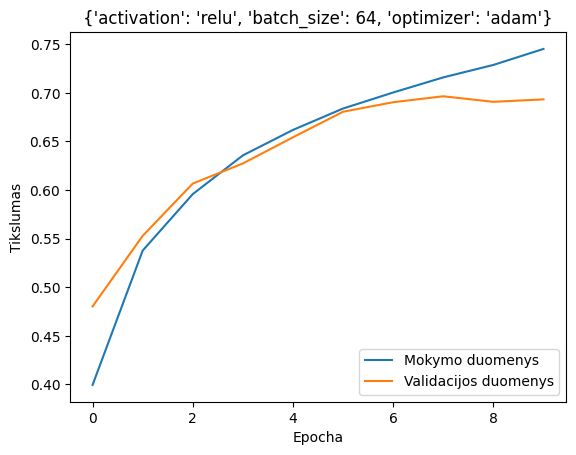

313/313 - 1s - loss: 0.9075 - accuracy: 0.6847 - 725ms/epoch - 2ms/step
Modelio tikslumas:  0.68


In [25]:
i = 3

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_1/assets
313/313 - 8s - loss: 2.2850 - accuracy: 0.1533 - val_loss: 2.2552 - val_accuracy: 0.1709 - 8s/epoch - 27ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_2/assets
313/313 - 8s - loss: 2.1669 - accuracy: 0.2176 - val_loss: 2.1095 - val_accuracy: 0.2402 - 8s/epoch - 26ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_3/assets
313/313 - 8s - loss: 2.0021 - accuracy: 0.2785 - val_loss: 1.9529 - val_accuracy: 0.2867 - 8s/epoch - 26ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_4/assets
313/313 - 9s - loss: 1.9026 - accuracy: 0.3182 - val_loss: 1.9279 - val_accuracy: 0.3161 - 9s/epoch - 27ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_4/epoch_5/assets
313/313 - 8s - loss: 1.8232 - accuracy: 0.3509 - val_loss: 1.8528 - val_accuracy: 0.3473 - 8s/epo

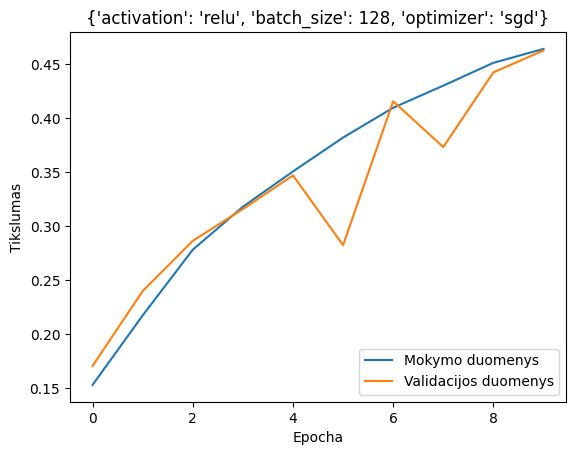

313/313 - 1s - loss: 1.4878 - accuracy: 0.4661 - 720ms/epoch - 2ms/step
Modelio tikslumas:  0.47


In [26]:
i = 4

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_1/assets
313/313 - 9s - loss: 1.7234 - accuracy: 0.3678 - val_loss: 1.4370 - val_accuracy: 0.4822 - 9s/epoch - 28ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_2/assets
313/313 - 9s - loss: 1.3661 - accuracy: 0.5061 - val_loss: 1.3480 - val_accuracy: 0.5208 - 9s/epoch - 27ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_3/assets
313/313 - 8s - loss: 1.2280 - accuracy: 0.5605 - val_loss: 1.1706 - val_accuracy: 0.5868 - 8s/epoch - 26ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_4/assets
313/313 - 8s - loss: 1.1199 - accuracy: 0.6041 - val_loss: 1.1113 - val_accuracy: 0.6143 - 8s/epoch - 26ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_5/epoch_5/assets
313/313 - 8s - loss: 1.0364 - accuracy: 0.6356 - val_loss: 1.0346 - val_accuracy: 0.6410 - 8s/epo

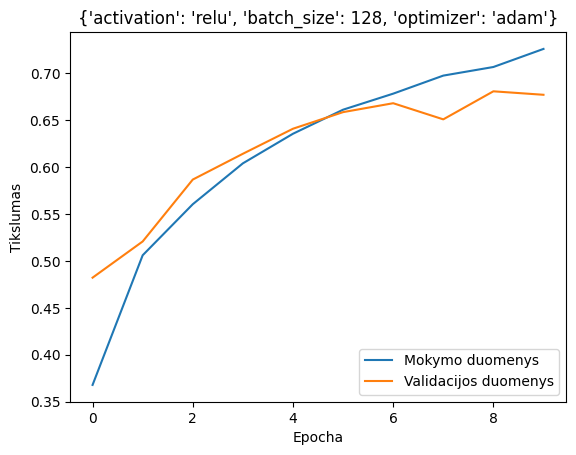

313/313 - 1s - loss: 0.9677 - accuracy: 0.6703 - 710ms/epoch - 2ms/step
Modelio tikslumas:  0.67


In [27]:
i = 5

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10


2022-09-29 09:21:09.236530: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_1/assets
1250/1250 - 12s - loss: 2.3070 - accuracy: 0.0991 - val_loss: 2.3042 - val_accuracy: 0.1003 - 12s/epoch - 10ms/step
Epoch 2/10
1250/1250 - 10s - loss: 2.3054 - accuracy: 0.0989 - val_loss: 2.3046 - val_accuracy: 0.1022 - 10s/epoch - 8ms/step
Epoch 3/10
1250/1250 - 11s - loss: 2.3055 - accuracy: 0.0973 - val_loss: 2.3048 - val_accuracy: 0.1022 - 11s/epoch - 8ms/step
Epoch 4/10
1250/1250 - 11s - loss: 2.3049 - accuracy: 0.1009 - val_loss: 2.3048 - val_accuracy: 0.1016 - 11s/epoch - 8ms/step
Epoch 5/10
1250/1250 - 11s - loss: 2.3049 - accuracy: 0.1012 - val_loss: 2.3052 - val_accuracy: 0.1003 - 11s/epoch - 8ms/step
Epoch 6/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_6/assets
1250/1250 - 11s - loss: 2.3052 - accuracy: 0.0996 - val_loss: 2.3037 - val_accuracy: 0.0952 - 11s/epoch - 9ms/step
Epoch 7/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_6/epoch_7/assets
125

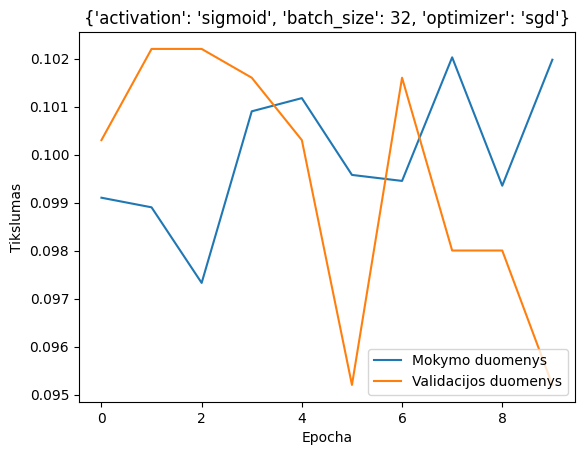

313/313 - 1s - loss: 2.3040 - accuracy: 0.1000 - 751ms/epoch - 2ms/step
Modelio tikslumas:  0.1


In [11]:
i = 6

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_1/assets
1250/1250 - 11s - loss: 2.0771 - accuracy: 0.2359 - val_loss: 1.8588 - val_accuracy: 0.3315 - 11s/epoch - 9ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_2/assets
1250/1250 - 11s - loss: 1.7256 - accuracy: 0.3786 - val_loss: 1.6331 - val_accuracy: 0.4063 - 11s/epoch - 9ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_3/assets
1250/1250 - 11s - loss: 1.5550 - accuracy: 0.4382 - val_loss: 1.5241 - val_accuracy: 0.4466 - 11s/epoch - 9ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_4/assets
1250/1250 - 11s - loss: 1.4737 - accuracy: 0.4689 - val_loss: 1.4436 - val_accuracy: 0.4804 - 11s/epoch - 9ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_7/epoch_5/assets
1250/1250 - 11s - loss: 1.4130 - accuracy: 0.4897 - val_loss: 1.3991 - val_accuracy: 

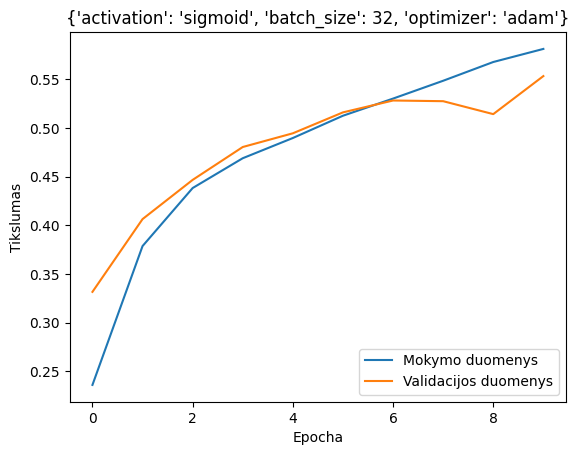

313/313 - 1s - loss: 1.2686 - accuracy: 0.5494 - 773ms/epoch - 2ms/step
Modelio tikslumas:  0.55


In [12]:
i = 7

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_8/epoch_1/assets
625/625 - 10s - loss: 2.3065 - accuracy: 0.0984 - val_loss: 2.3041 - val_accuracy: 0.1014 - 10s/epoch - 16ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_8/epoch_2/assets
625/625 - 9s - loss: 2.3044 - accuracy: 0.0989 - val_loss: 2.3034 - val_accuracy: 0.1014 - 9s/epoch - 15ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_8/epoch_3/assets
625/625 - 9s - loss: 2.3044 - accuracy: 0.1003 - val_loss: 2.3029 - val_accuracy: 0.1005 - 9s/epoch - 15ms/step
Epoch 4/10
625/625 - 9s - loss: 2.3041 - accuracy: 0.0978 - val_loss: 2.3041 - val_accuracy: 0.1022 - 9s/epoch - 14ms/step
Epoch 5/10
625/625 - 9s - loss: 2.3043 - accuracy: 0.1001 - val_loss: 2.3034 - val_accuracy: 0.1003 - 9s/epoch - 14ms/step
Epoch 6/10
625/625 - 9s - loss: 2.3041 - accuracy: 0.1002 - val_loss: 2.3032 - val_accuracy: 0.1016 - 9s/epoch - 14ms/step
Epoch 7/10
625/625 -

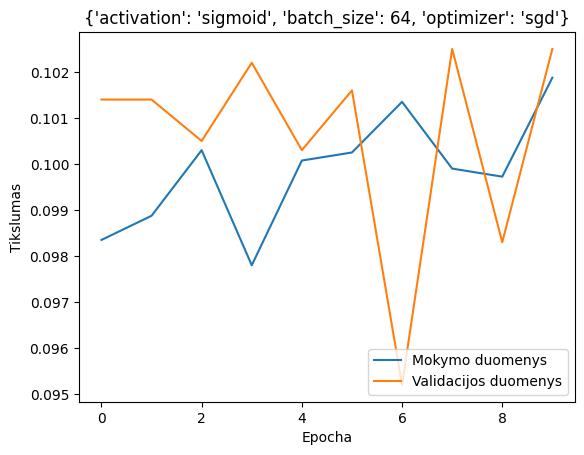

313/313 - 1s - loss: 2.3039 - accuracy: 0.1005 - 754ms/epoch - 2ms/step
Modelio tikslumas:  0.1


In [13]:
i = 8

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_1/assets
625/625 - 10s - loss: 2.2931 - accuracy: 0.1129 - val_loss: 2.1088 - val_accuracy: 0.2371 - 10s/epoch - 16ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_2/assets
625/625 - 9s - loss: 1.9532 - accuracy: 0.2886 - val_loss: 1.9003 - val_accuracy: 0.3105 - 9s/epoch - 15ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_3/assets
625/625 - 9s - loss: 1.7580 - accuracy: 0.3701 - val_loss: 1.7000 - val_accuracy: 0.3864 - 9s/epoch - 15ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_4/assets
625/625 - 9s - loss: 1.6323 - accuracy: 0.4150 - val_loss: 1.6161 - val_accuracy: 0.4245 - 9s/epoch - 15ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_9/epoch_5/assets
625/625 - 9s - loss: 1.5475 - accuracy: 0.4456 - val_loss: 1.5815 - val_accuracy: 0.4372 - 9s/e

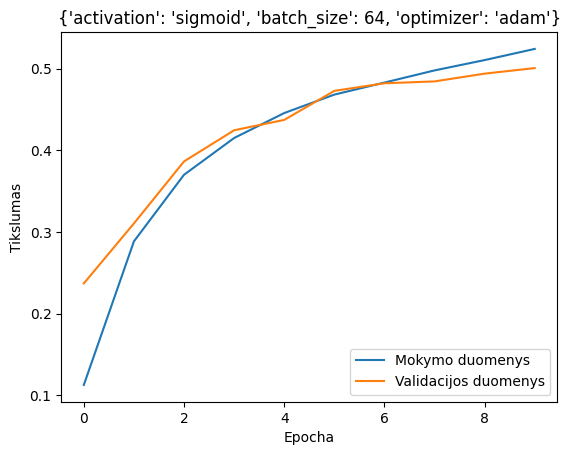

313/313 - 1s - loss: 1.3805 - accuracy: 0.5032 - 775ms/epoch - 2ms/step
Modelio tikslumas:  0.5


In [14]:
i = 9

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_10/epoch_1/assets
313/313 - 9s - loss: 2.3194 - accuracy: 0.0994 - val_loss: 2.3037 - val_accuracy: 0.0997 - 9s/epoch - 29ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_10/epoch_2/assets
313/313 - 8s - loss: 2.3034 - accuracy: 0.0984 - val_loss: 2.3025 - val_accuracy: 0.1016 - 8s/epoch - 27ms/step
Epoch 3/10
313/313 - 8s - loss: 2.3035 - accuracy: 0.0975 - val_loss: 2.3029 - val_accuracy: 0.1012 - 8s/epoch - 25ms/step
Epoch 4/10
313/313 - 8s - loss: 2.3033 - accuracy: 0.0975 - val_loss: 2.3028 - val_accuracy: 0.0980 - 8s/epoch - 25ms/step
Epoch 5/10
313/313 - 8s - loss: 2.3033 - accuracy: 0.0992 - val_loss: 2.3040 - val_accuracy: 0.0997 - 8s/epoch - 25ms/step
Epoch 6/10
313/313 - 8s - loss: 2.3034 - accuracy: 0.0994 - val_loss: 2.3033 - val_accuracy: 0.0997 - 8s/epoch - 25ms/step
Epoch 7/10
313/313 - 8s - loss: 2.3033 - accuracy: 0.0976 - val_loss: 2.3027 - val_accuracy: 0.1016 

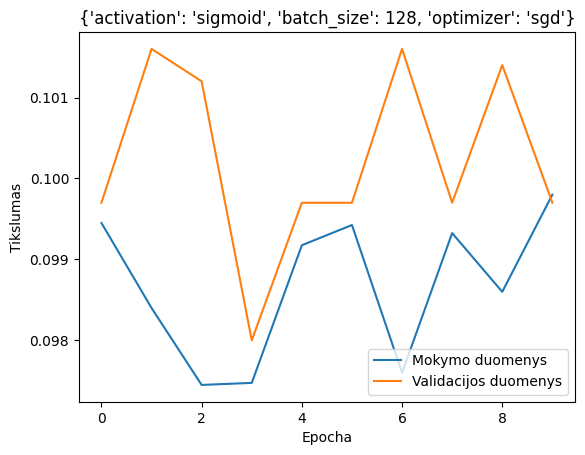

313/313 - 1s - loss: 2.3033 - accuracy: 0.1000 - 760ms/epoch - 2ms/step
Modelio tikslumas:  0.1


In [15]:
i = 10

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

Epoch 1/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_1/assets
313/313 - 9s - loss: 2.2529 - accuracy: 0.1349 - val_loss: 2.0526 - val_accuracy: 0.2505 - 9s/epoch - 28ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_2/assets
313/313 - 8s - loss: 1.9878 - accuracy: 0.2661 - val_loss: 1.9508 - val_accuracy: 0.2735 - 8s/epoch - 26ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_3/assets
313/313 - 8s - loss: 1.9161 - accuracy: 0.2954 - val_loss: 1.8885 - val_accuracy: 0.3064 - 8s/epoch - 27ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_4/assets
313/313 - 8s - loss: 1.8326 - accuracy: 0.3362 - val_loss: 1.7727 - val_accuracy: 0.3643 - 8s/epoch - 26ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: modeliai/hyperparameter_set_11/epoch_5/assets
313/313 - 8s - loss: 1.7135 - accuracy: 0.3888 - val_loss: 1.6791 - val_accuracy: 0.3970 - 8

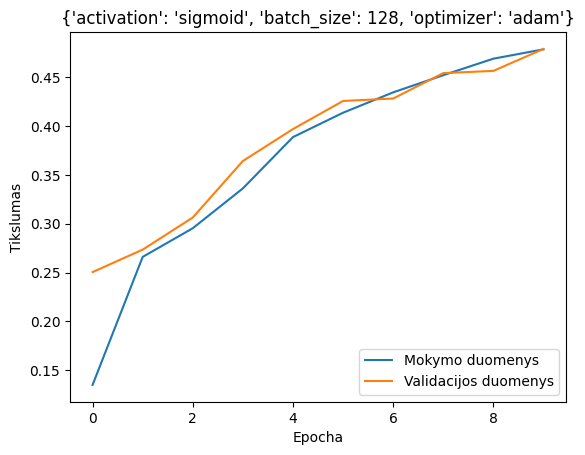

313/313 - 1s - loss: 1.4529 - accuracy: 0.4805 - 770ms/epoch - 2ms/step
Modelio tikslumas:  0.48


In [16]:
i = 11

model, history, accuracy = pipeline(train_images,train_labels,test_images,test_labels,
                                    **grid[i],attempt = i)
test_accuracies.append(accuracy)
models.append(model)
histories.append(history)

### Geriausio modelio parinkimas

In [60]:
results["test_accuracies"] = np.round_(test_accuracies,2)
results

,activation,batch_size,optimizer,test_accuracies
0,relu,32,sgd,0.59
1,relu,32,adam,0.70
2,relu,64,sgd,0.54
3,relu,64,adam,0.68
4,relu,128,sgd,0.47
5,relu,128,adam,0.67
6,sigmoid,32,sgd,0.10
7,sigmoid,32,adam,0.55
8,sigmoid,64,sgd,0.10
9,sigmoid,64,adam,0.50


In [62]:
model = models[np.argmax(test_accuracies)]
# Geriausias sudarytas modelis išsaugomas
model.save("modeliai/geriausias")
best_model = tf.keras.models.load_model("modeliai/geriausias")

INFO:tensorflow:Assets written to: modeliai/geriausias/assets


In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = best_model.predict(test_images)
y_pred = [np.argmax(i) for i in y_pred]
confusion_matrix = confusion_matrix(test_labels, y_pred)
print(confusion_matrix)

test_accuracy = accuracy_score(test_labels, y_pred)
print("Geriausio modelio tikslumas: ", round(test_accuracy,2))

[[746  20  55  16  23   4  11   9  84  32]
 [ 29 826   7   8   4   1   7   3  35  80]
 [ 78   6 580  66 122  54  50  16  17  11]
 [ 21  10  82 543  90 125  49  39  24  17]
 [ 21   8  56  73 693  38  42  56  10   3]
 [ 19   7  68 209  52 569  15  36  15  10]
 [ 11   4  56  92  43  28 740   7  12   7]
 [ 21   4  52  49  78  56   8 713   7  12]
 [ 71  35  13  17   9   4   3   2 822  24]
 [ 43  86   6  17   4   8   9  15  26 786]]
Geriausio modelio tikslumas:  0.7


In [103]:
from sklearn.metrics import classification_report

# greitas būdas pažiūrėti kaip gerai klasifikuojama kiekviena klasė
results_frame = pd.DataFrame(classification_report(test_labels,y_pred,output_dict=True))
results_frame.columns = np.concatenate((classes_labels,results_frame.columns[10:].values))
results_frame

,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck,accuracy,macro avg,weighted avg
precision,0.703774,0.821074,0.594872,0.498165,0.619857,0.641488,0.792291,0.795759,0.781369,0.800407,0.7018,0.704906,0.704906
recall,0.746000,0.826000,0.580000,0.543000,0.693000,0.569000,0.740000,0.713000,0.822000,0.786000,0.7018,0.701800,0.701800
f1-score,0.724272,0.823529,0.587342,0.519617,0.654391,0.603074,0.765253,0.752110,0.801170,0.793138,0.7018,0.702390,0.702390
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.7018,10000.000000,10000.000000


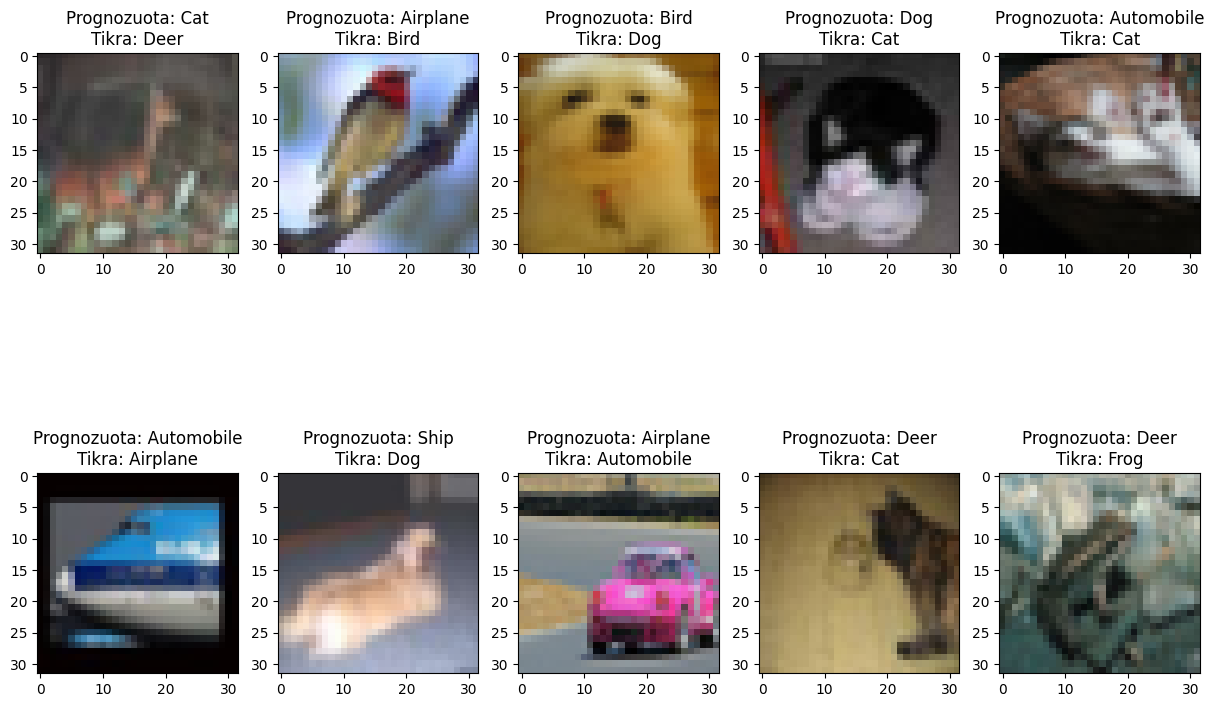

In [147]:
# Kelių neteisingų prognozių pavyzdžiai
wrong_indices = np.random.choice(np.where(y_pred != test_labels[:,0])[0],10)
fig, ax = plt.subplots(2,5,figsize=(15, 10))
for i in range(0,10):
    indice = wrong_indices[i]
    ax[i//5,i%5].imshow(test_images[indice])
    ax[i//5,i%5].set_title("Prognozuota: " + classes_labels[y_pred[indice]] +
                           "\n" + 
                           "Tikra: " + classes_labels[test_labels[indice][0]]) 

In [158]:
print("Keli atsitiktiniai stebėjimai iš testavimo aibės:")
tikra = []
prognozuota = []
teisinga = []
indices = np.random.choice(np.where(np.array(y_pred) == np.array(y_pred))[0],30)
for i in indices:
    teisinga.append(y_pred[i] == test_labels[i][0]),
    prognozuota.append(classes_labels[y_pred[i]]),
    tikra.append(classes_labels[test_labels[i][0]])
    
pd.DataFrame({"Teisinga":teisinga,"Tikra":tikra,"Prognozuota":prognozuota})

Keli atsitiktiniai stebėjimai iš testavimo aibės:


,Teisinga,Tikra,Prognozuota
0,True,Dog,Dog
1,True,Horse,Horse
2,True,Cat,Cat
3,True,Ship,Ship
4,False,Cat,Bird
5,True,Ship,Ship
6,True,Truck,Truck
7,True,Deer,Deer
8,True,Truck,Truck
9,True,Ship,Ship
